# CIGO Data scientist Challenge

## Motivación 

Somos un centro de Transformación Digital Interna que busca de manera innovadora mejorar los procesos del Banco adoptando prácticas ágiles

Nos encargamos de impulsar las iniciativas de los funcionarios como si fueran Emprendedores, Tomamos el concepto de incubadoras acompañándolos y empoderándolos  para que sus iniciativas sean materializadas con mínimas soluciones viables, rápidas y eficientes.

En CIGO buscamos explorar nuevas iniciativas  con Inteligencia artificial que nos permita aumentar la productividad y los espacios de trabajo de tal forma podamos tener un crecimiento exponencial en ingresos y disminución de costos administrativos, en el equipo CIGO buscamos transformar el Banco con nuevas tendencias tecnológicas y nuevas formas de trabajo.

## Consigna 

El objetivo de este desafío consiste en utilizar un conjunto de datos proporcionados

El cual consiste en textos generados tanto por Modelos de Lenguaje Largos (LLM) tales como Chatgpt, Llama2 entre otros, como por autores humanos.  El reto es doble:

### Análisis de estilo: 

Realizar el proceso de exploración y análisis sobre los textos para cada texto (EDA), logrando identificar elementos o aspectos distintivos en el estilo de texto generado por los LLMs en comparación con los creados por los humanos.

In [1]:
#libreriaa necesarias
#nltk
import nltk
nltk.download('stopwords')
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#tensorflow-keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text
from keras import utils


#sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve,auc
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler


import matplotlib.pyplot as plt
import numpy as np
import re
import string

[nltk_data] Downloading package stopwords to /home/sergio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-12-15 03:56:24.519214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 03:56:24.570553: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 03:56:24.572713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 03:56:25.446671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#importamos los datos
data=pd.read_excel("./data/database_clean.xlsx")
data.drop_duplicates(inplace=True)

Se realiza un función para el primer preprocesamiento de el téxto, en donde se arregla algunos formatos de tíldes que están erroneos en los datos y se realiza un preprocesamiento a los tweets ya que algunos de estos poseen liks y hastags que no son nesesarios para este proceso 

In [3]:
# Se corrigen algunos caracteres existentes en los textos, como lo son errores en lectura de tíldes y simbolos caracteristicos usados en tweets
def prerpocesamiento(texto):
    diccionario_tildes= {
        "Ã¡": "á",
        "Ã©": "é",
        "Ã": "í",
        "Ã³": "ó",
        "Ãº": "ú",
        "Ã±": "ñ",
    }
    for mal_codificado, bien_codificado in diccionario_tildes.items():
        texto = texto.replace(mal_codificado, bien_codificado)

    #preprocesamiento para los tweets
    # remover el símbolo de retweet "rt"
    texto = re.sub(r'^RT[\s]+', '', texto)
    # remover los liks
    texto = re.sub(r'https?://[^\s\n\r]+', '', texto)

    # remover hashtags
    # solo se remueven los # de las palabras
    texto = re.sub(r'#', '', texto)



    return texto

data.drop_duplicates(inplace=True)
#Corrección de caracteres existentes en los textos
data["Texto"]=data["Texto"].str.replace('\xad', '')
#Correccipón de tíldes
data["Texto"]=data["Texto"].apply(prerpocesamiento)
#se binariza la columna de clasificación
data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])

Se extrae una lista con las stopwords para el vocabulario en español, las stopwords son palabras que suelen ser preposiciones, conjunciones, artículos y otras palabras comunes que aparecen con frecuencia en un texto

In [4]:
stop_words = set(stopwords.words('spanish'))
print(stop_words)

{'fuéramos', 'nos', 'ha', 'sois', 'eres', 'fuiste', 'habréis', 'una', 'fueras', 'nada', 'todos', 'para', 'tuvierais', 'soy', 'tenían', 'fuisteis', 'del', 'estando', 'estuvo', 'tendrías', 'hubiéramos', 'tuvimos', 'esos', 'tienen', 'habrías', 'tendríais', 'fuesen', 'ya', 'está', 'nosotros', 'haya', 'hubiésemos', 'no', 'estabais', 'teníamos', 'era', 'cual', 'te', 'estas', 'tendré', 'ese', 'os', 'tuve', 'también', 'tuvieron', 'por', 'algunos', 'seamos', 'hubieseis', 'tendríamos', 'tuviese', 'estar', 'cuando', 'tú', 'habremos', 'e', 'hasta', 'porque', 'desde', 'tendrá', 'contra', 'poco', 'ellas', 'sentidas', 'este', 'sean', 'a', 'estuvimos', 'tuviste', 'en', 'tuvieses', 'sin', 'habré', 'estarás', 'sentido', 'quien', 'otro', 'otra', 'tengamos', 'siente', 'estado', 'habidos', 'de', 'un', 'hubieran', 'habías', 'hubiese', 'han', 'estéis', 'sea', 'fuimos', 'estuvierais', 'estuviera', 'fueron', 'hubieses', 'tenido', 'pero', 'seríais', 'habrán', 'vuestra', 'algunas', 'hemos', 'fue', 'fueses', 'vue

se definen una función con la extracción de caracteristicas de el téxto que nos va a ser útil para encontrar patrones que pueden diferenciar a un texto escrito por un modelo de LLM o un humano, así mismo nos pueden ayudar a entrenar un modelo con estás características, esta función permite encontrar:

- El número de stop words que existe en cada texto dividido por la cantidad de palabras en el mismo
- El número de palabras únicas que existe en cada texto dividido por la cantidad de palabras en el mismo
- El número de palabras que contengan al menos una mayuscula en cada texto dividido por la cantidad de palabras en el mismo
- El número de signos de puntuación en cada texto dividido por la cantidad de palabras en el mismo
- la cantidad de palabras queestán repetidas en cada texto dividido por la cantidad de palabras en el mismo

In [5]:
def extraccion_caracteristicas(texto):
    def total_palabras(texto):
        total=len(word_tokenize(texto))
        return total

    def numero_stop_words_por_texto(texto,):
        total=total_palabras(texto)
        texto=word_tokenize(texto)
        stopwords_x = [w for w in texto if w in stop_words]
        num_stopw=len(stopwords_x)
        num_stopw_per_total= num_stopw / total if total else 0
        return num_stopw_per_total

    def numero_palabras_unicas_por_texto(texto):
        total=total_palabras(texto)
        texto=word_tokenize(texto)
        unicos = len([*set(texto)])
        unicos_per_text=unicos / total if total else 0
        return unicos_per_text

    def palabras_mayusculas_por_texto(texto):
        total=total_palabras(texto)
        palabras_con_mayusculas = len([palabra for palabra in texto.split() if any(letra.isupper() for letra in palabra)])
        palabras_con_mayusculas_per_text=palabras_con_mayusculas / total if total else 0
        return palabras_con_mayusculas_per_text

    def signos_puntuacion_por_texto(texto):
        total=total_palabras(texto)
        cantidad_signos = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))
        num=cantidad_signos(texto, string.punctuation)
        return num / total if total else 0

    def palabras_repetidas_por_texto(texto):
        total=total_palabras(texto)
        conteo_palabra = {}
        words = word_tokenize(texto)
        for palabra in words:
            # Remove punctuation if necessary, convert to lowercase, etc.
            palabra = palabra.strip().lower()  # Adjust as needed
            conteo_palabra[palabra] = conteo_palabra.get(palabra, 0) + 1
        num=np.sum(np.array(list(conteo_palabra.values()))-1)
        return num / total if total else 0
    

    return pd.Series([numero_stop_words_por_texto(texto),numero_palabras_unicas_por_texto(texto),signos_puntuacion_por_texto(texto),palabras_mayusculas_por_texto(texto),palabras_repetidas_por_texto(texto)])



Se almacenan los datos mencionados anteriormente en su debida columna en el dataset

In [6]:
data[['stop_words/texto','numero_palabras_unicas/texto','signos_puntuacion/texto','palabras_mayusculas/texto','palabras_repetidas/texto']]=data["Texto"].apply(extraccion_caracteristicas)
data=data[data['palabras_repetidas/texto']!=0]

In [7]:
data.head(5)

,Texto,Tipo de fuente,Clasificacion,type,stop_words/texto,numero_palabras_unicas/texto,signos_puntuacion/texto,palabras_mayusculas/texto,palabras_repetidas/texto
0,El rey de los animales Se reunieron los animal...,Cuentos,Human,0,0.370892,0.376761,0.166667,0.110329,0.645540
1,Domingo 7 Había una vez dos compadres jorobado...,Cuentos,Human,0,0.411960,0.390365,0.104651,0.068937,0.629568
2,Francisco El Hombre En los albores del siglo X...,Cuentos,Human,0,0.378271,0.441713,0.114195,0.082474,0.574148
3,Aminta Peláez- La leyenda de Wareke Hace muchí...,Cuentos,Human,0,0.432731,0.343373,0.128514,0.063253,0.675703
4,EL OASIS DE BELISSAMA ATLAUA pASeABA Con BeLis...,Cuentos,Human,0,0.376963,0.680628,0.094241,0.120419,0.392670


<Axes: xlabel='Tipo de fuente'>

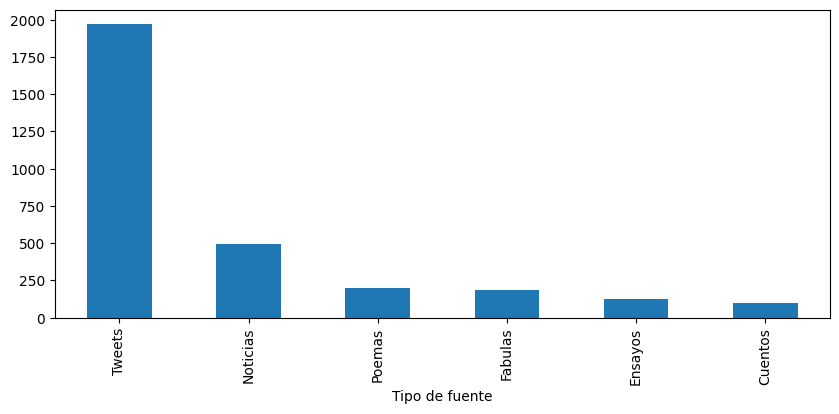

In [8]:
my_tags = list(data["Tipo de fuente"].unique())
plt.figure(figsize=(10,4))
data["Tipo de fuente"].value_counts().plot(kind='bar')


In [9]:
cantidad_datos_tipo=data["Tipo de fuente"].value_counts()
print(cantidad_datos_tipo)

Tipo de fuente
Tweets      1969
Noticias     496
Poemas       198
Fabulas      184
Ensayos      127
Cuentos       99
Name: count, dtype: int64


In [10]:
print("el porcentaje de tweets existentes en dataset representa un {}%".format(round(cantidad_datos_tipo["Tweets"]/len(data)*100,2)))

el porcentaje de tweets existentes en dataset representa un 64.07%


Se puede ver que en el dataset se tiene un mayor posentaje de datos en tweets representando un 70 % de nuestros datos

([<matplotlib.axis.XTick at 0x7f9343a83850>,
 [Text(1, 0, 'Human'), Text(2, 0, 'LLM')])

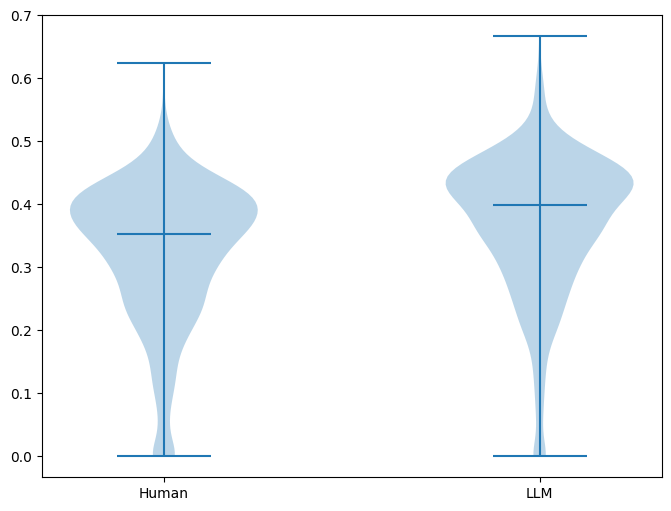

In [11]:
plt.figure(figsize=(8, 6))
plt.violinplot([data[(data["type"]==0)]["stop_words/texto"], data[(data["type"]==1)]["stop_words/texto"]], showmedians=True)
plt.xticks([1, 2], ['Human', 'LLM'])

En la imagen de diagrama de violín se puede afirmar que proporción de stopwords son usadas con más frecuencia en los modelos de lenguaje largo (LLM) que en los humanos, aunque esta diferencia no es muy signifiactiva

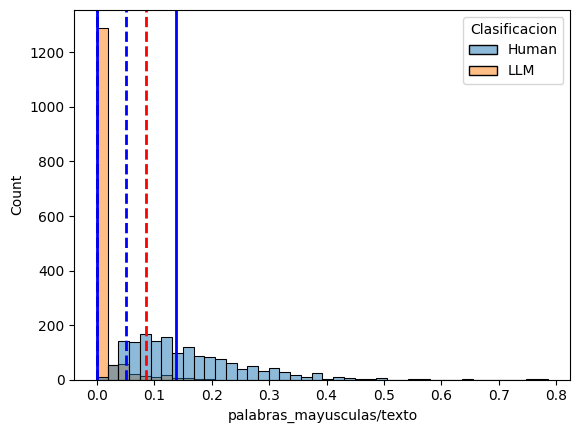

In [12]:
import seaborn as sns

sns.histplot(data=data,x='palabras_mayusculas/texto',hue='Clasificacion')

plt.axvline(x=data["palabras_mayusculas/texto"].mean(),color='red',linestyle='dashed',linewidth=2)
plt.axvline(x=data["palabras_mayusculas/texto"].median(),color='blue',linestyle='dashed',linewidth=2)
plt.axvline(x=data["palabras_mayusculas/texto"].mode().max(),color='black',linestyle='dashed',linewidth=2)
plt.axvline(x=data["palabras_mayusculas/texto"].quantile(0.25),color='blue',linewidth=2)
plt.axvline(x=data["palabras_mayusculas/texto"].quantile(0.75),color='blue',linewidth=2)



en este ejemplo se puede ver que las palabras en los textos que poseen almenos una mayuscula esán precentes en en los textos generados por humanos, en cambio en los modelos de lenguaje largo estos textos usualmento no llevan palabras en mayuscula

<Axes: xlabel='numero_palabras_unicas/texto', ylabel='palabras_repetidas/texto'>

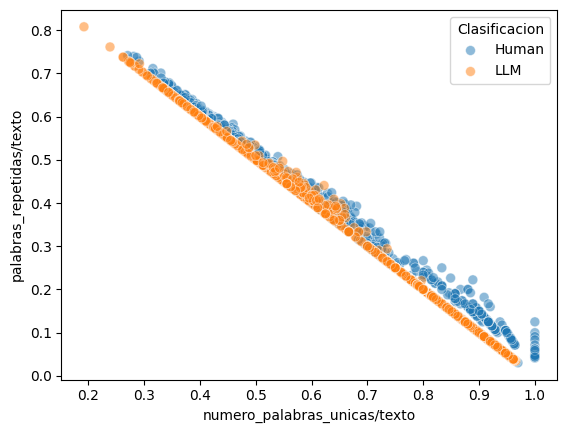

In [13]:
sns.scatterplot(data=data,x='numero_palabras_unicas/texto',y='palabras_repetidas/texto',alpha=1/2,s=50,hue="Clasificacion")

Es gráfica representa que si se compara dos de nuestras variables extraidas a partir del texto podemos ver que pueden ser casi linealmente separables, asi que se puede usar una Suport vector machine para encontrar un hiperplano capaz de separa nuestros datos a travez de el aumento en la dimensión de nuestras variables

### Clasificación de textos:

Desarrollar un modelo de aprendizaje automático capaz de realizar la clasificación de los textos según autoría es decir basándose en la columna clasificación y un modelo por cada tipo de fuente, reportando sus respectivas métricas F1, matriz de confusión o la que considere pertinente para este caso de uso. RECOMENDACIÓN: Para el último punto puede iterar el mismo modelo por cada tipo de fuente y generar los resultados y métricas.

- Se realiza el modelo de clasificación diferenciando si el texto está escrito por un LLM o un humano, para esto se va a usar una SVM

In [14]:
datos_interes=data[data['Tipo de fuente']=="Tweets"][['type','stop_words/texto','numero_palabras_unicas/texto','signos_puntuacion/texto','palabras_mayusculas/texto','palabras_repetidas/texto']]
datos_interes

,type,stop_words/texto,numero_palabras_unicas/texto,signos_puntuacion/texto,palabras_mayusculas/texto,palabras_repetidas/texto
555,0,0.473684,0.894737,0.000000,0.157895,0.157895
556,0,0.380952,0.952381,0.000000,0.142857,0.047619
557,0,0.346154,0.923077,0.153846,0.076923,0.076923
558,0,0.473684,1.000000,0.052632,0.157895,0.052632
559,0,0.428571,0.857143,0.095238,0.190476,0.142857
...,...,...,...,...,...,...
3833,1,0.458333,0.791667,0.083333,0.000000,0.208333
3839,1,0.461538,0.846154,0.076923,0.000000,0.153846
3841,1,0.413793,0.793103,0.068966,0.000000,0.206897
3844,1,0.500000,0.750000,0.062500,0.000000,0.250000


Se define una función para mostrar y graficar los resultados de los modelos según un modelo de clasificación binaria

In [15]:
def metricas(y_test,y_pred,traget):
        # Se avalúa el rendimiento del mdoelo 
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred,target_names=traget))

    # Matríz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=traget, yticklabels=traget)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.show()

## SVM para clasificar si el texto está escrito por un LLM o un Humano

Accuracy: 0.949238578680203
              precision    recall  f1-score   support

         LLM       0.97      0.94      0.95       313
      Humano       0.93      0.96      0.95       278

    accuracy                           0.95       591
   macro avg       0.95      0.95      0.95       591
weighted avg       0.95      0.95      0.95       591



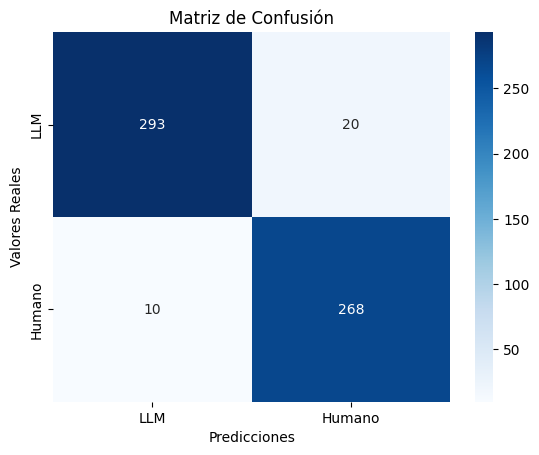

In [16]:
terget_name_bin=["LLM","Humano"]
# Se separan los datos
X = datos_interes.drop('type', axis=1)
y = datos_interes['type']

# Se divide el conunto de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Se normalizan los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# se crea la SVM y se entrena con los datos de entrenamiento
svm_classifier = SVC(kernel='linear') 
svm_classifier.fit(X_train, y_train)

# Se predicen los resultados según nuestos datos en test
y_pred = svm_classifier.predict(X_test)

metricas(y_test,y_pred,terget_name_bin)


In [17]:
def ROC(y_test, y_pred):
    fpr, tpr, thresholds =roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Trazar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

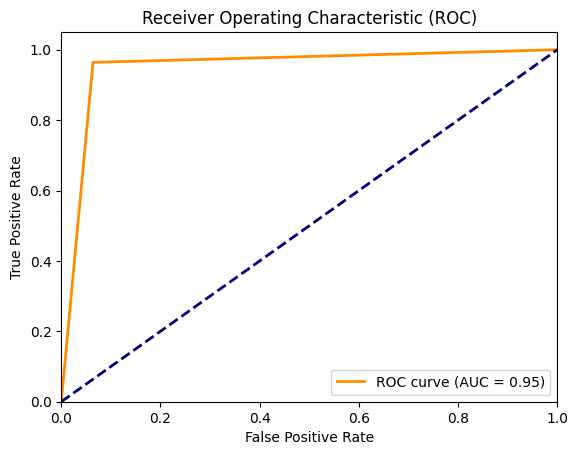

In [18]:
ROC(y_test, y_pred)

## Decision Tree para clasificar si el texto está escrito por un LLM o un Humano

Accuracy: 0.9560067681895094
              precision    recall  f1-score   support

         LLM       0.94      0.97      0.96       313
      Humano       0.97      0.94      0.95       278

    accuracy                           0.96       591
   macro avg       0.96      0.95      0.96       591
weighted avg       0.96      0.96      0.96       591



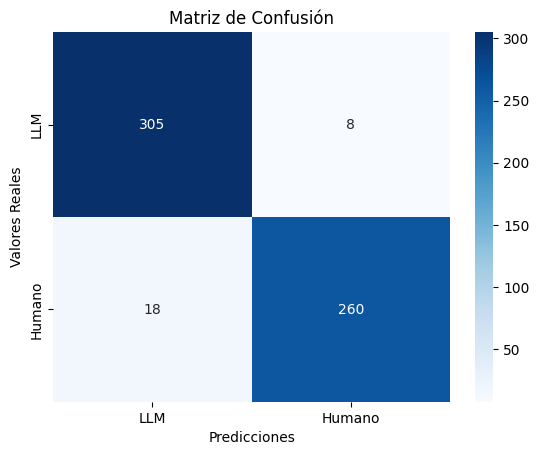

In [19]:
# se crea el árbol de decisión y se entrena con los datos de entrenamiento
TreeDes = DecisionTreeClassifier(max_depth=4, random_state=42)

# se crea la SVM y se entrena con los datos de entrenamiento
TreeDes.fit(X_train, y_train)
y_pred=TreeDes.predict(X_test)

# Se predicen los resultados según nuestos datos en test
metricas(y_test,y_pred,terget_name_bin)


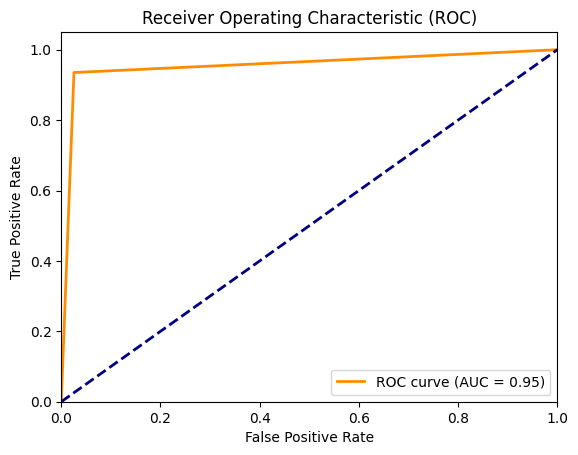

In [20]:
ROC(y_test,y_pred)

Para los dos modelos se obtubo un resultado parecido en cuanto a accuracy, hay una pequeña diferencia en que el modelo basado en árboles de decision puede clasificar de una mejor manera si el modelo está escrito por un humano obteniendo una mayor cantidad de falsos negativos, los dos modelos pueden ser útiles para la clasificación que ya que las métricas de recall y f-score son addecuadas para elegir cualquiera de los dos, en este caso se elegirá el modelo basado en SVM pos su efectividad a la hora de elegir textos escritos por humanos

In [21]:
import pickle
with open('./Models/modelo_Clasificacion.pkl','wb') as f:
    pickle.dump(svm_classifier,f)


### Preprocesamiento de los datos

para identificar el tipo de texto, se puede tomar en base las palabras más comúnes según el tipo de texto apoyandonos en herramientas especializadas en NLP

se crea otra función de procesamiento de texto, en donde descartamos stopwords t hacemos una limpieza a los datos tipo string

In [22]:
REEMPLAZAR_ESPACIO = re.compile('[/(){}\[\]\|@,;]')
SIMBOLOS_INCORRECTOS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def prerpocesamiento_tipo_text(texto):
    """
        text:  string
        
        return: strin modificado
    """
    #diccionario en donde se reemplazan algunos caracteres mal procesados
    diccionario_tildes= {
        "Ã¡": "á",
        "Ã©": "é",
        "Ã": "í",
        "Ã³": "ó",
        "Ãº": "ú",
        "Ã±": "ñ",
    }
    for mal_codificado, bien_codificado in diccionario_tildes.items():
        texto = texto.replace(mal_codificado, bien_codificado)

    texto = texto.lower() # se convierte todo el texto a su versión en munuscula
    texto=texto.replace('\xad', '')
    texto = REEMPLAZAR_ESPACIO.sub(' ', texto) # replace REPLACE_BY_SPACE_RE symbols by space in text
    texto = SIMBOLOS_INCORRECTOS.sub('', texto) # delete symbols which are in BAD_SYMBOLS_RE from text
    texto = ' '.join(word for word in texto.split() if word not in STOPWORDS) # delete stopwors from text
    return texto

In [23]:
data['texto_procesado'] = data['Texto'].apply(prerpocesamiento_tipo_text)

se desrcartan aquellos textos que despues de procesarlos solamente poseen una palabra

In [24]:
data['num_words']=data['texto_procesado'].apply(lambda x: len(x.split()))
data=data[data['num_words']>1]

se dividen los datos en test y train

In [25]:
X =data.texto_procesado
y = data["Tipo de fuente"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

Se inicia con el modelo de clasificar el tipo de fuente, primero se intenta con una maquina de soporte vectorial lineal 

## SVM Lineal para clasificar tipo de texto

In [26]:
from sklearn.linear_model import SGDClassifier

"""se define el pipeline con:
 -CountVectorizer:se crea una representación numerica según la frecuencia de la palabra en el texto
 -TfidfTransformer: se asignan pesos según CountVectorizer
 -SGDClassifier: se define el clasificador de descenso del gradiente, definiendo la funmción de error, la penalización L2 para evitar sobreajuste,apha para controlar
                la penalización, numero máximo de iteraciones"""

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

Accuracy: 0.9566160520607375
              precision    recall  f1-score   support

     Cuentos       0.86      0.64      0.73        28
     Ensayos       1.00      0.97      0.98        29
     Fabulas       0.96      0.80      0.87        54
    Noticias       0.97      0.96      0.96       137
      Poemas       0.93      0.82      0.87        67
      Tweets       0.96      1.00      0.98       607

    accuracy                           0.96       922
   macro avg       0.95      0.86      0.90       922
weighted avg       0.96      0.96      0.95       922



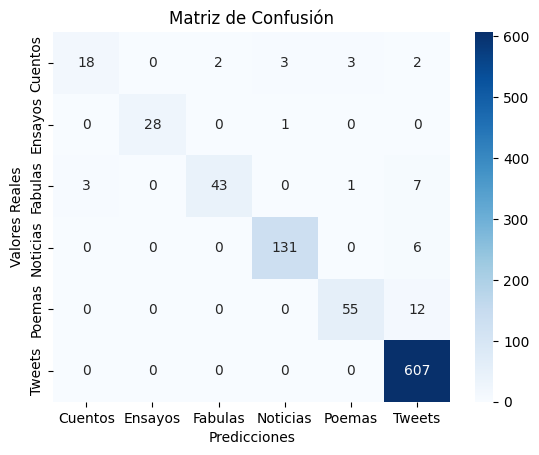

In [27]:
y_pred = sgd.predict(X_test)
metricas(y_test, y_pred,my_tags)

Resultados:

-as

## Bag of words (BOW) con keras para clasificar tipo de texto

In [28]:
#se hace una tokenización de nuestros datos string
max_words=6000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train
x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

#se conviete el label en forma vectorial
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [29]:
"""se construye el modelo, para esto definimos red neuronal sequencial con una capa densa de 240 y 
la capa de entrada del tamaño de nuestro numero máximo de palabras por texto que vendrían siendo 600, la función de activación es relu,
se añade una capa de dropout para prevenir sobreajuste
luego una capa densa de salida con el numero de calses ya se transformó el label en una represenatción vectorial,
y la función de activación de la capa de salida es softmax porque queremos predecir multiclase"""
model = Sequential()
model.add(Dense(240, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2023-12-15 03:56:59.992400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 03:56:59.993156: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [30]:
#se entrena el modelo a 5 épocas y se asigna un set de validacion de 10% de neustros datos de train
model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
61/61 [==============================] - 2s 30ms/step - loss: 1.0243 - accuracy: 0.8387 - val_loss: 0.3849 - val_accuracy: 0.9721
Epoch 2/5
61/61 [==============================] - 2s 26ms/step - loss: 0.1625 - accuracy: 0.9886 - val_loss: 0.1437 - val_accuracy: 0.9721
Epoch 3/5
61/61 [==============================] - 1s 24ms/step - loss: 0.0427 - accuracy: 0.9984 - val_loss: 0.1125 - val_accuracy: 0.9767
Epoch 4/5
61/61 [==============================] - 1s 24ms/step - loss: 0.0198 - accuracy: 0.9984 - val_loss: 0.1074 - val_accuracy: 0.9721
Epoch 5/5
61/61 [==============================] - 1s 18ms/step - loss: 0.0130 - accuracy: 0.9979 - val_loss: 0.1052 - val_accuracy: 0.9767


In [31]:

y_pred = model.predict(x_test) 
y_pred=np.argmax(y_pred,axis=1)              ## xtest => test image


29/29 [==============================] - 0s 3ms/step


Accuracy: 0.9815618221258134
              precision    recall  f1-score   support

     Cuentos       0.96      0.79      0.86        28
     Ensayos       1.00      0.97      0.98        29
     Fabulas       0.98      0.96      0.97        54
    Noticias       0.99      0.99      0.99       137
      Poemas       0.95      0.91      0.93        67
      Tweets       0.98      1.00      0.99       607

    accuracy                           0.98       922
   macro avg       0.98      0.94      0.95       922
weighted avg       0.98      0.98      0.98       922



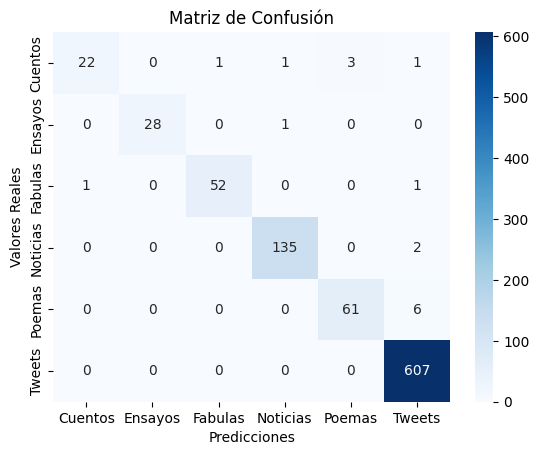

In [32]:
metricas(np.argmax(y_test,axis=1),y_pred, my_tags)

En este caso se elige la red neuronal ya que tiene mayor exactitud , junto con mejor precision en cuanto a la prediccion de todos los labels

In [33]:
model.save('./Models/Tipo_texto.keras') 

In [34]:
#se exporta el scaler y el tokenizer
import joblib
joblib.dump(scaler, './Models/scaler_model.joblib')
joblib.dump(tokenize, './Models/tokenizer_model.joblib')
joblib.dump(encoder, './Models/encoder_model.joblib')


['./Models/encoder_model.joblib']

# Prueba Modelos

Se cargan los modelos

In [35]:
with open('./Models/modelo_Clasificacion.pkl', 'rb') as f:
    Clasificacion = pickle.load(f)

Tipo_Texto = keras.models.load_model('./Models/Tipo_texto.keras')

In [36]:
def prueba_modelo_calss(text):
    data=pd.DataFrame(index=[1])
    texto_limpio=prerpocesamiento_tipo_text(text)
    data[['stop_words/texto','numero_palabras_unicas/texto','signos_puntuacion/texto','palabras_mayusculas/texto','palabras_repetidas/texto']]=extraccion_caracteristicas(text)
    datos=scaler.transform(data)
    pred=Clasificacion.predict(datos)
    if pred[0]==0:
        clase="Humano"
    else:
        clase="LLM"
    
    return clase

In [37]:
def prueba_modelo_tipo(texto,tokenizer):
    texto_limpio=pd.Series([prerpocesamiento_tipo_text(texto)])
    tokenizado=tokenizer.texts_to_matrix(texto_limpio)
    prediccion=Tipo_Texto.predict(tokenizado)
    predict_tipo=encoder.inverse_transform([prediccion[0].argmax()])
    return predict_tipo[0]


In [38]:
texto_ejemplo_poema="En la penumbra de la noche sosegada, donde las estrellas sus secretos revelan, mi mente vuela en alas de la nada, donde los sueños como luciérnagas destellan.Bajo el manto plateado de la luna, se tejen historias en el silencio, donde el corazón, como una fortuna, se llena de anhelos en este trance eterno.Susurros de hojas danzan con el viento, mientras la noche abraza el suspenso, y en el lienzo del cielo, un firmamento, pintado con los sueños que llevo dentro.Allí, donde los recuerdos se entrelazan, y las sombras danzan con la melodía, se despiertan los sueños que abrazan, la esperanza en esta mágica poesía.Que las estrellas guarden mis secretos, y la luna cuente mis anhelos, en este rincón de sueños discretos, donde la noche se convierte en cielo."

In [39]:
print(prueba_modelo_tipo(texto_ejemplo_poema,tokenize))
print(prueba_modelo_calss(texto_ejemplo_poema))

1/1 [==============================] - 0s 65ms/step
Poemas
LLM


In [40]:
texto_ejemplo_fabulas="Había una vez, en un pequeño rincón del bosque, un ratón llamado Nino. Aunque pequeño de estatura, Nino era conocido por su astucia y agilidad. Un día, mientras exploraba el bosque en busca de comida, se encontró con un gato sabio llamado Simón."

In [41]:
print(prueba_modelo_tipo(texto_ejemplo_fabulas,tokenize))
print(prueba_modelo_calss(texto_ejemplo_fabulas))

1/1 [==============================] - 0s 20ms/step
Fabulas
Humano
